# Quantum Temporal Anomaly Detection for Unique Attendance Dataset

In this notebook, we present our solution...

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dtaidistance import dtw
import itertools
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import random

df = pd.read_csv("data_weeks.csv", header=None)


In [80]:
# NORMALIZATION BY ROW
rows = df.values
for row in rows:
    line_values = row[1:]
    norm_row = (line_values - line_values.min()) / (line_values.max() - line_values.min())
    row[1:] = norm_row

df_norm = pd.DataFrame(rows)
#print(df_norm.head)

first_column = df_norm.columns[0]
df_norm = df_norm.drop(columns=first_column)


In [81]:
CONFIGS = {
    "TRAIN_SAMPLES" : 50,
    "NORMAL_SAMPLES" : 20,
    "ANOMALY_SAMPLES" : 20,
}

In [82]:
def generate_random_time_series(leng=672, seed=None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    else:
        np.random.seed()
        random.seed()
    
    indices = np.arange(leng)
    
    # Generate reduced noise and interpolate
    reduced_noise = np.random.normal(0, 0.5, int(leng/30))
    x_old = np.linspace(0, leng, len(reduced_noise))
    x_new = np.linspace(0, leng, leng)
    extended_noise = np.interp(x_new, x_old, reduced_noise)
    extended_noise = np.concatenate((np.zeros(leng - len(extended_noise)), extended_noise))
    
    # Create random noise
    noise = np.random.normal(0, 0.02, leng)
    
    def scaling_amplitude(x):
        centrality_factor = abs(x - np.mean(x))
        y = 1.2 - (random.random() - 0.5) * centrality_factor * np.cos(random.random() * np.pi * 0.1 * x + random.random() * 0.2)
        return y
    
    def scaled_sine_wave(x):
        offset = random.random() * 10
        return 0.5 * np.sin(2 * np.pi * x / 96 + offset) + 0.5
    
    def scaled_line(x):
        return (x - 0.5)**2 + x * 0.1
    
    x_scaled = indices / leng + noise
    ts = scaled_sine_wave(indices) * scaling_amplitude(x_scaled) * (1 + extended_noise) + 2 * scaled_line(x_scaled)
    
    # Normalize to 0-1
    ts_min = np.min(ts)
    ts_max = np.max(ts)
    ts_normalized = (ts - ts_min) / (ts_max - ts_min)
    
    return ts_normalized

In [83]:

np.random.seed(0)
all_indices = np.arange(df_norm.shape[0])
train_indices = np.random.choice(all_indices, CONFIGS["TRAIN_SAMPLES"], replace=False)
remaining_indices = np.setdiff1d(all_indices, train_indices)
test_indices = np.random.choice(remaining_indices, CONFIGS["NORMAL_SAMPLES"], replace=False)
# save them as matrixes
train = df_norm.iloc[train_indices].values
test = df_norm.iloc[test_indices].values
# save the matrixes in csv files
np.savetxt("train_norm.csv", train, delimiter=",", fmt="%s")
np.savetxt("test_norm.csv", test, delimiter=",", fmt="%s")
# print the shapes
print('Train shape:', train.shape)
print('Test shape:', test.shape)

anomaly_series = []
for i in range(CONFIGS["ANOMALY_SAMPLES"]):
    ts = generate_random_time_series(seed=i)
    anomaly_series.append(ts)
anomaly_series = np.array(anomaly_series)

# ====================================================================================================

Train shape: (50, 672)
Test shape: (20, 672)


In [84]:
def calculate_temporal_similarity(series1, series2):
    distance, paths = dtw.warping_paths(series1, series2, use_c=False)
    best_path = dtw.best_path(paths)
    similarity_score = distance / len(best_path)
    return similarity_score

In [85]:
TYPES = {"TRAIN_KERNEL", "TEST_KERNEL", "ANOMALY_KERNEL"}

def generate_custom_kernel(DATASET1, DATASET2, TYPE, function, to_swap = True):
    if TYPE == "TRAIN_KERNEL":
        similarity_matrix = np.zeros((DATASET1.shape[0], DATASET1.shape[0]))
        train_combinations = list(itertools.combinations(range(DATASET1.shape[0]), 2))
        for i, j in tqdm(train_combinations):
        # series 1 is the first row
            X1 = DATASET1[i]
            # series 2 is the second row
            X2 = DATASET2[j]
            # Ensure both series are the same length before applying DTW
            assert len(X1) == len(X2)

            similarity_score = function(X1, X2)
            similarity_matrix[i, j] = similarity_score
            similarity_matrix[j, i] = similarity_score  # Symmetric matrix

        if to_swap:
            similarity_matrix = 1 - (similarity_matrix / np.max(similarity_matrix))
        np.fill_diagonal(similarity_matrix, 1)

    elif TYPE == "TEST_KERNEL" or TYPE == "ANOMALY_KERNEL":
        similarity_matrix = np.zeros((DATASET1.shape[0], DATASET2.shape[0]))
        test_combinations = list(itertools.product(range(DATASET1.shape[0]), range(DATASET2.shape[0])))
        for i, j in tqdm(test_combinations):
            X1 = DATASET1[i]
            X2 = DATASET2[j]

            similarity_score = function(X1, X2)
            similarity_matrix[i, j] = similarity_score
    
        if to_swap:
                similarity_matrix = 1 - (similarity_matrix / np.max(similarity_matrix))
    return similarity_matrix

In [86]:
def standard_model(train, test, anomaly, kernel_code):
    one_class_svm = OneClassSVM(kernel=kernel_code, nu=0.1)
    one_class_svm.fit(train)
    test_predictions = one_class_svm.predict(test)
    anomaly_predictions = one_class_svm.predict(anomaly)

    # compute accuracy of normal samples
    test_labels = np.ones(test.shape[0])
    test_accuracy = accuracy_score(test_labels, test_predictions)

    # compute accuracy of anomaly samples
    anomaly_labels = -1 * np.ones(anomaly.shape[0])
    anomaly_accuracy = accuracy_score(anomaly_labels, anomaly_predictions)

    print(f"Accuracy on normal samples: {test_accuracy}")
    print(f"Accuracy on anomaly samples: {anomaly_accuracy}")



In [87]:
def custom_model(train_kernel, test_kernel, anomaly_kernel, info):
    one_class_svm = OneClassSVM(kernel='precomputed', nu=0.1)
    one_class_svm.fit(train_kernel)
    test_predictions = one_class_svm.predict(test_kernel)
    anomaly_predictions = one_class_svm.predict(anomaly_kernel)

    # compute accuracy of normal samples
    test_labels = np.ones(test_kernel.shape[0])
    test_accuracy = accuracy_score(test_labels, test_predictions)

    # compute accuracy of anomaly samples
    anomaly_labels = -1 * np.ones(anomaly_kernel.shape[0])
    anomaly_accuracy = accuracy_score(anomaly_labels, anomaly_predictions)

    print(f"Accuracy on normal samples: {test_accuracy}")
    print(f"Accuracy on anomaly samples: {anomaly_accuracy}")
    print(info)


In [88]:
K_train = generate_custom_kernel(train, train, "TRAIN_KERNEL", calculate_temporal_similarity)
K_test = generate_custom_kernel(test, train, "TEST_KERNEL", calculate_temporal_similarity)
K_anomaly = generate_custom_kernel(anomaly_series, train, "ANOMALY_KERNEL", calculate_temporal_similarity)


  2%|▏         | 20/1225 [00:16<16:54,  1.19it/s]


KeyboardInterrupt: 

In [59]:
custom_model(K_train, K_test, K_anomaly, "DTW")

Accuracy on normal samples: 0.95
Accuracy on anomaly samples: 1.0
DTW


In [60]:
standard_model(train, test, anomaly_series, 'linear')
standard_model(train, test, anomaly_series, 'rbf')
standard_model(train, test, anomaly_series, 'poly')


Accuracy on normal samples: 0.75
Accuracy on anomaly samples: 0.8
Accuracy on normal samples: 0.75
Accuracy on anomaly samples: 1.0
Accuracy on normal samples: 0.75
Accuracy on anomaly samples: 0.9


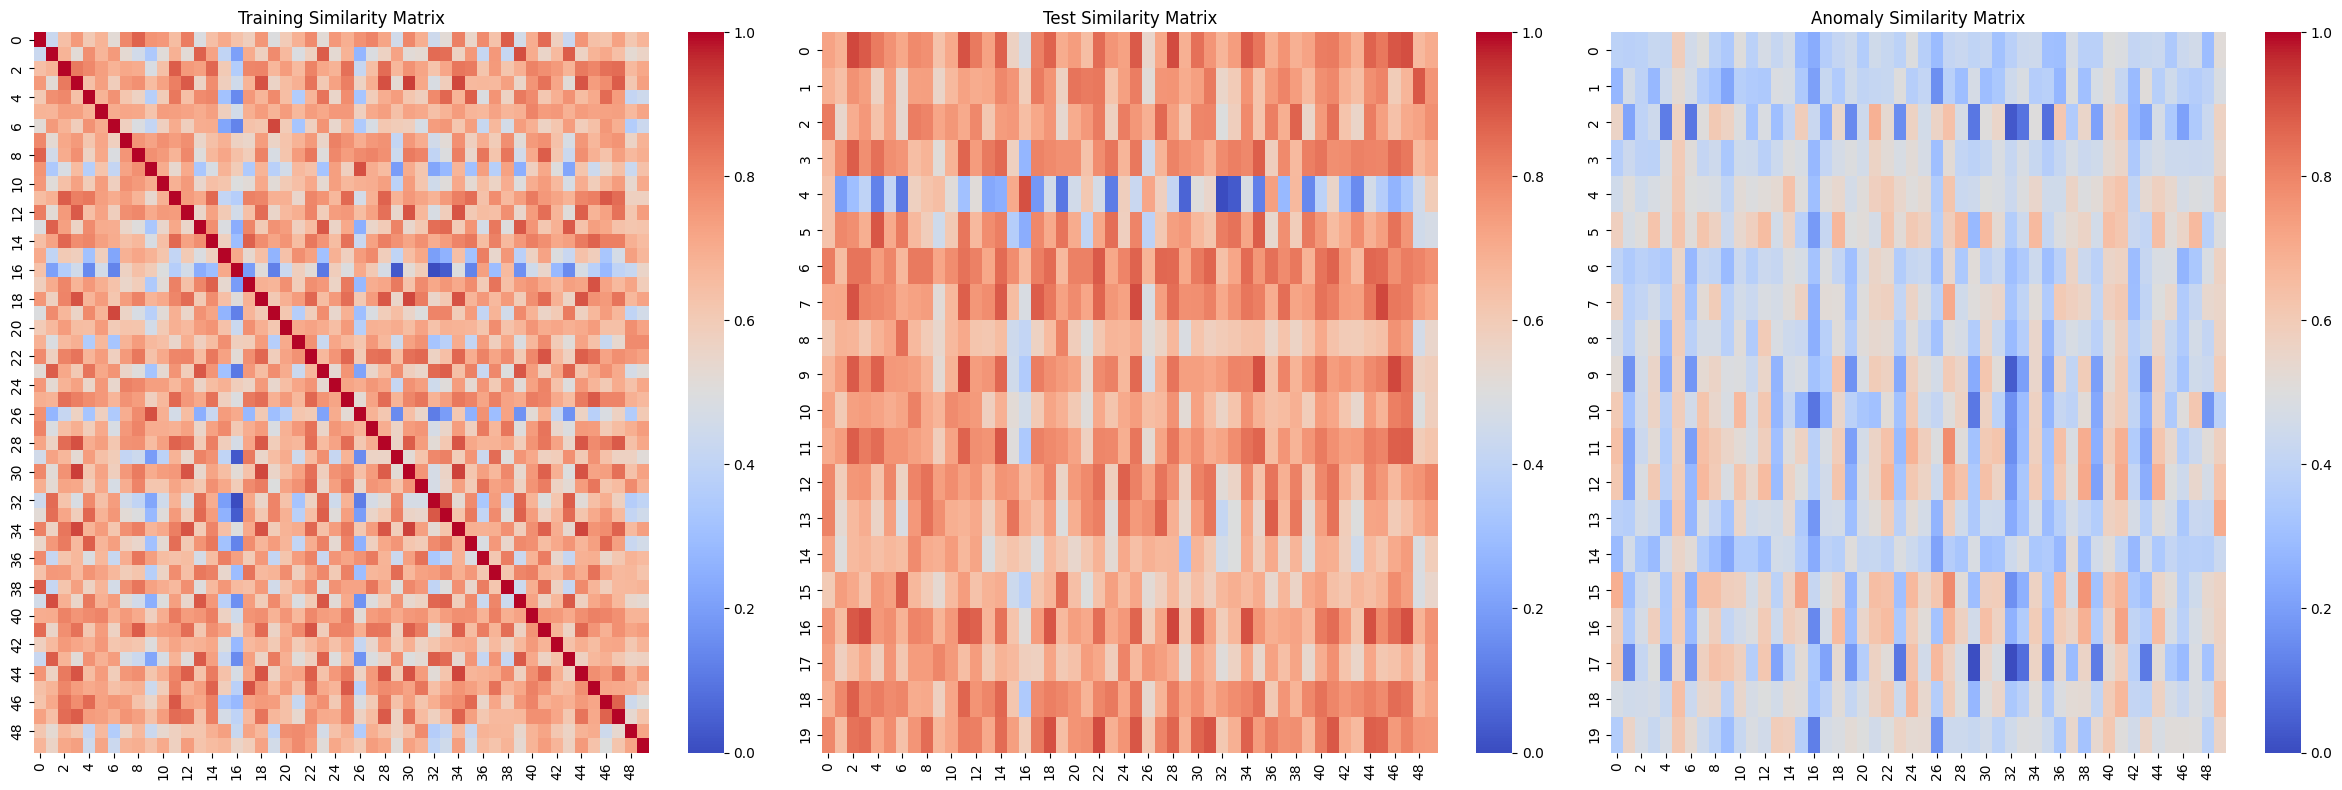

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

TO_PRINT = True
if TO_PRINT:
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # Create a grid with 1 row and 3 columns

    # Training Similarity Matrix
    sns.heatmap(K_train, annot=False, cmap='coolwarm', vmin=0, vmax=1, ax=axes[0])
    axes[0].set_title('Training Similarity Matrix')

    # Test Similarity Matrix
    sns.heatmap(K_test, annot=False, cmap='coolwarm', vmin=0, vmax=1, ax=axes[1])
    axes[1].set_title('Test Similarity Matrix')

    # Anomaly Similarity Matrix
    sns.heatmap(K_anomaly, annot=False, cmap='coolwarm', vmin=0, vmax=1, ax=axes[2])
    axes[2].set_title('Anomaly Similarity Matrix')

    plt.tight_layout()  # Adjusts spacing to prevent overlap
    plt.show()


# Quantum Stuff


In [89]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.primitives.sampler import Sampler

from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
import numpy as np
from scipy.linalg import expm

H_X = np.array([[0, 1],
                [1, 0]]) 

# use H as pauli Y gate
H_Y = np.array([[0, -1j],
                [1j, 0]])

H_Z = np.array([[1, 0],
                [0, -1]])

H_I = np.eye(2)

H_weights = np.random.rand(4)

H = H_weights[0] * H_X + H_weights[1] * H_Y + H_weights[2] * H_Z + H_weights[3] * H_I

def evaluate_inner_product(x1, x2, leng, t, H):
# Create the two quantum states |ψ⟩ and |φ⟩
    psi = QuantumCircuit(1)
    phi = QuantumCircuit(1)
    U = expm(-1j * H * 2*np.pi*t/leng)

    psi.unitary(Operator(U), [0])

    psi.rx(x1**2*np.pi, 0)
    psi.ry(x1*np.pi, 0)
    #psi.rz(x1*np.pi*2, 0)
    
    phi.unitary(Operator(U), [0])

    phi.rx(x2**2*np.pi, 0)
    phi.ry(x2*np.pi, 0)
    #phi.rz(x2*np.pi*2, 0)



    psi_inv = psi.inverse()

    #compose the circuits
    phi.compose(psi_inv, inplace=True)
    #print(phi)
    # Combine the circuits to measure the inner product
    qc_measured = phi.measure_all(inplace=False)

    # 3. Execute using the Sampler primitive

    sampler = Sampler()
    job = sampler.run(qc_measured, shots=1000)
    result = job.result()
    #print(f" > Quasi probability distribution: {result.quasi_dists}")
    try:
        inner_product = result.quasi_dists[0][0]
    except:
        inner_product = 0
    return inner_product

In [90]:
import random

random.seed(0)
np.random.seed(0)

my_leng = 672
weights = np.random.rand(my_leng)
for i in range(len(weights)):
    if random.random() < 0.95:
        weights[i] = 0
#print(weights)
# normalize weights such that their sum is 1
weights = weights / np.sum(weights)    
#print(weights)

print(f"Non-zero weights: {np.count_nonzero(weights)}")

def evaluate_Qkernel_similarity(x1, x2, custom_inner_product):
    assert len(x1) == len(x2)
    leng = len(x1)
    kernel_value = 0
    for t in range(leng):
        if weights[t] != 0:
            kernel_value += weights[t] * custom_inner_product(x1[t], x2[t], leng, t, H)
    return kernel_value
    

def my_qkernel(x1, x2):
    return evaluate_Qkernel_similarity(x1, x2, evaluate_inner_product)

Non-zero weights: 32


In [91]:
K_train = generate_custom_kernel(train, train, "TRAIN_KERNEL", my_qkernel, to_swap=False)
K_test = generate_custom_kernel(test, train, "TEST_KERNEL", my_qkernel, to_swap=False)
K_anomaly = generate_custom_kernel(anomaly_series, train, "ANOMALY_KERNEL", my_qkernel, to_swap=False)
custom_model(K_train, K_test, K_anomaly, "quantum kernel")


100%|██████████| 1000/1000 [02:08<00:00,  7.80it/s]

Accuracy on normal samples: 0.95
Accuracy on anomaly samples: 0.6
quantum kernel


In [93]:
import os
import numpy as np
import csv

#assert False, "Stop here"

# Define folder name
folder_name = "exp_sparse_95_60_X2Y"

# Create the folder if it doesn't exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Function to save a matrix to a CSV file
def save_matrix(matrix, filename):
    filepath = os.path.join(folder_name, filename)
    with open(filepath, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(matrix)

save_matrix(K_train, "K_train.csv")
save_matrix(K_test, "K_test.csv")
save_matrix(K_anomaly, "K_anomaly.csv")

print(f"Matrices saved in folder '{folder_name}'")


Matrices saved in folder 'exp_sparse_95_60_X2Y'


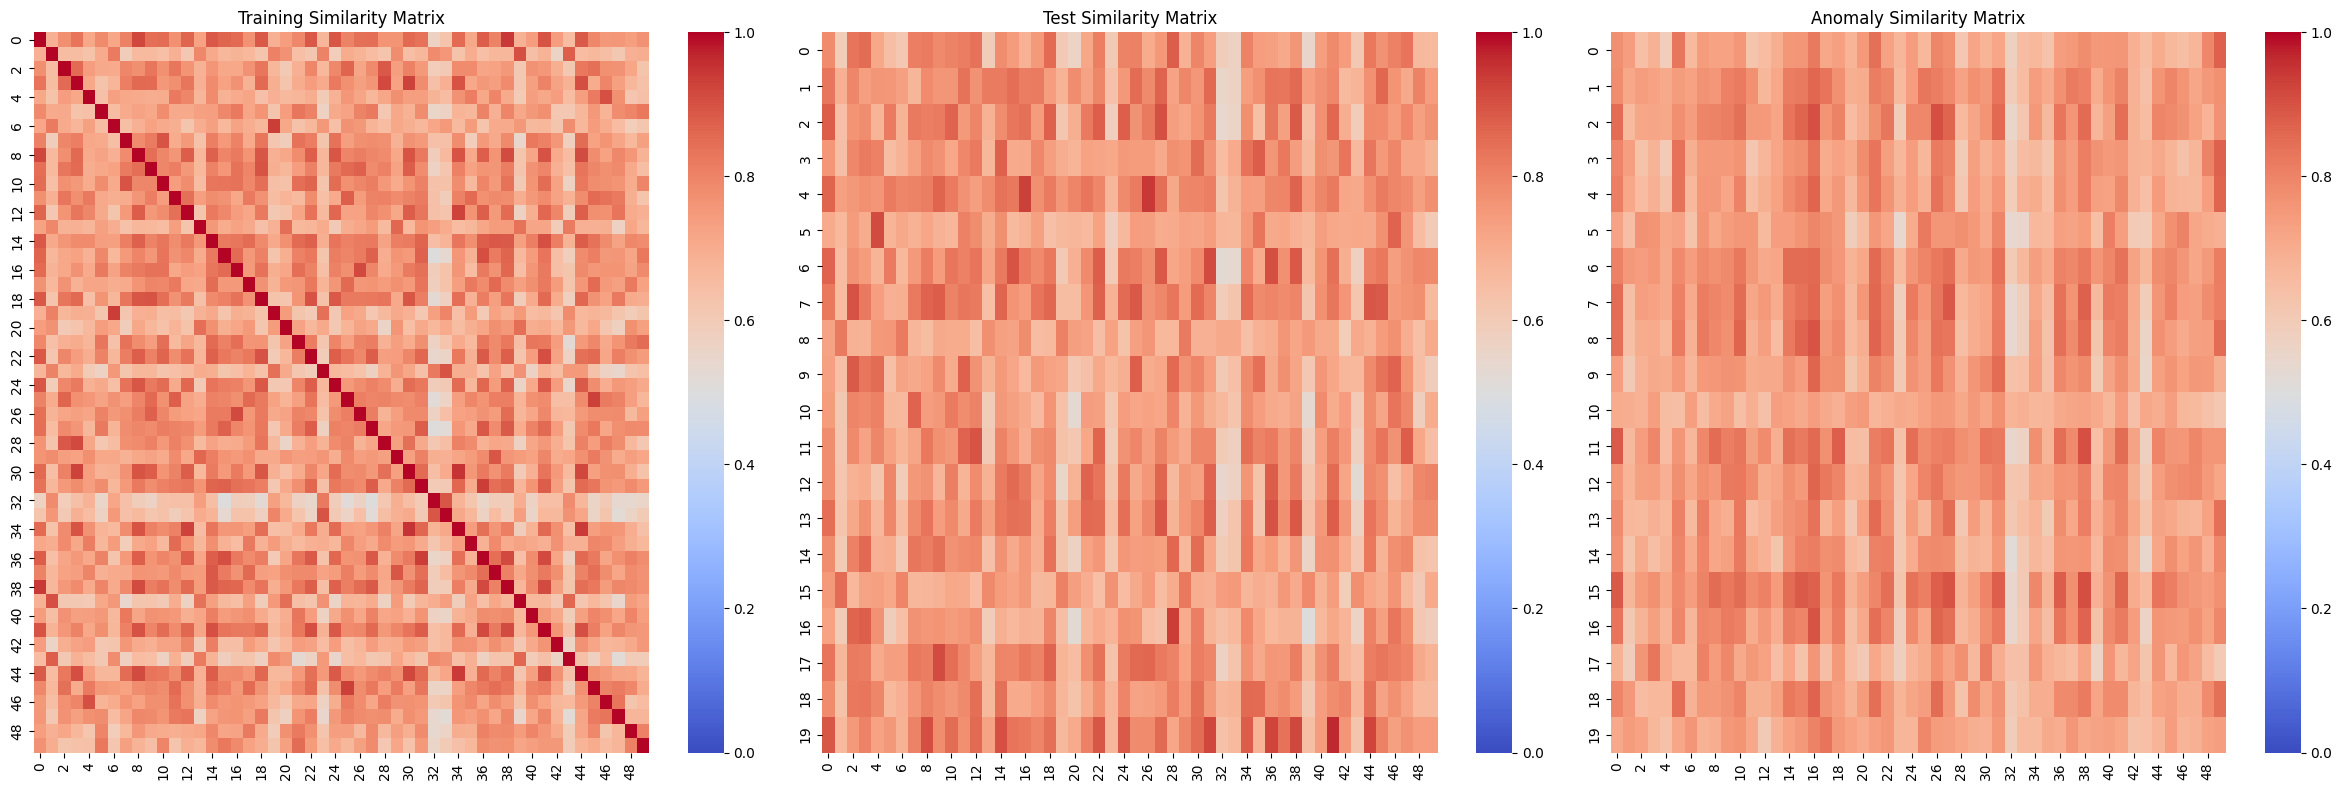

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

TO_PRINT = True
if TO_PRINT:
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # Create a grid with 1 row and 3 columns

    # Training Similarity Matrix
    sns.heatmap(K_train, annot=False, cmap='coolwarm', vmin=0, vmax=1, ax=axes[0])
    axes[0].set_title('Training Similarity Matrix')

    # Test Similarity Matrix
    sns.heatmap(K_test, annot=False, cmap='coolwarm', vmin=0, vmax=1, ax=axes[1])
    axes[1].set_title('Test Similarity Matrix')

    # Anomaly Similarity Matrix
    sns.heatmap(K_anomaly, annot=False, cmap='coolwarm', vmin=0, vmax=1, ax=axes[2])
    axes[2].set_title('Anomaly Similarity Matrix')

    plt.tight_layout()  # Adjusts spacing to prevent overlap
    plt.show()
